In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Shape of x_data: (50000, 32, 32, 3)
Shape of y_data: (50000, 1)


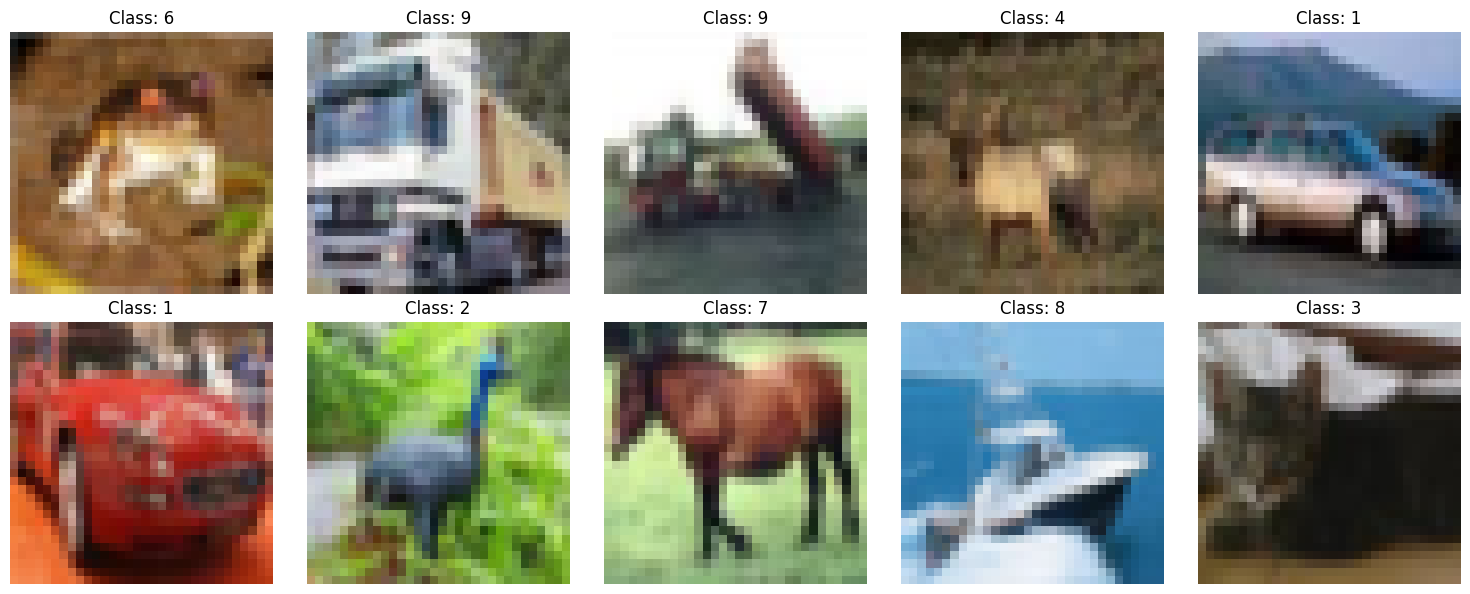

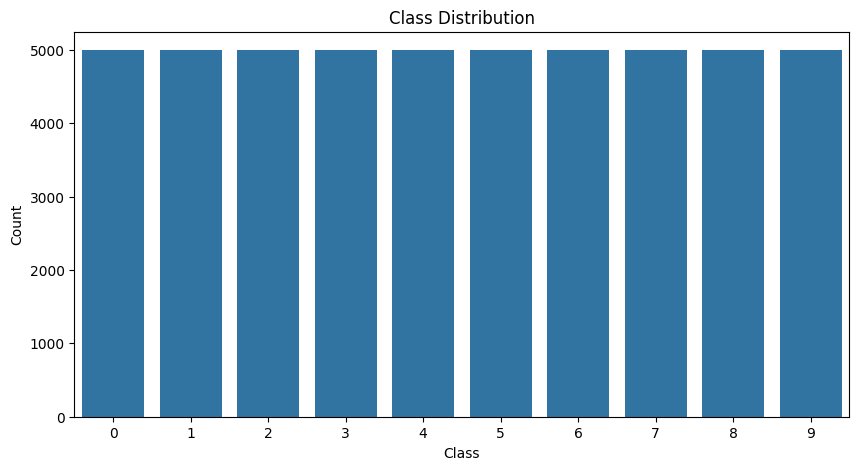

Mean per channel (R, G, B): [125.30691805 122.95039414 113.86538318]
Standard deviation per channel (R, G, B): [62.99321928 62.08870764 66.70489964]


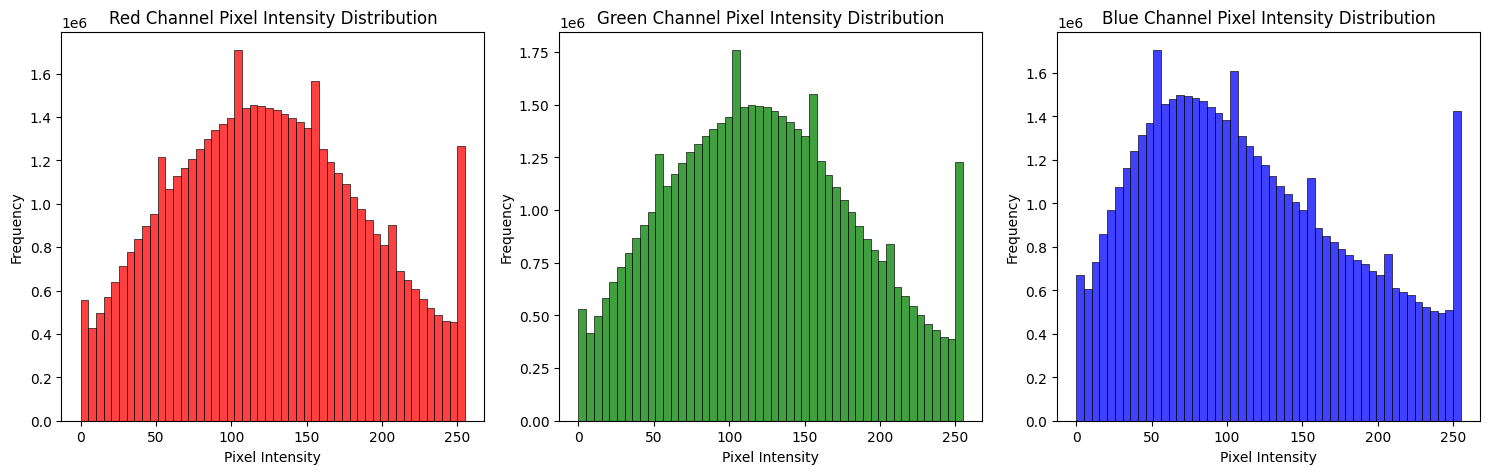

In [3]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Exploratory Data Analysis (EDA)
def perform_eda(x_data, y_data):
    print(f"Shape of x_data: {x_data.shape}")
    print(f"Shape of y_data: {y_data.shape}")

    # Display sample images
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    for i in range(10):
        axes[i].imshow(x_data[i])
        axes[i].set_title(f"Class: {y_data[i][0]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Plot class distribution
    class_counts = np.bincount(y_data.flatten())
    plt.figure(figsize=(10, 5))
    sns.barplot(x=range(10), y=class_counts)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

# Perform EDA on training data
perform_eda(x_train, y_train)

# Calculate mean and standard deviation for each color channel (RGB)
mean_per_channel = np.mean(x_train, axis=(0, 1, 2))
std_per_channel = np.std(x_train, axis=(0, 1, 2))

print("Mean per channel (R, G, B):", mean_per_channel)
print("Standard deviation per channel (R, G, B):", std_per_channel)

# Plot pixel intensity distributions for each color channel
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
colors = ['r', 'g', 'b']
channels = ['Red', 'Green', 'Blue']

for i in range(3):
    sns.histplot(x_train[:, :, :, i].flatten(), bins=50, color=colors[i], ax=ax[i])
    ax[i].set_title(f"{channels[i]} Channel Pixel Intensity Distribution")
    ax[i].set_xlabel("Pixel Intensity")
    ax[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

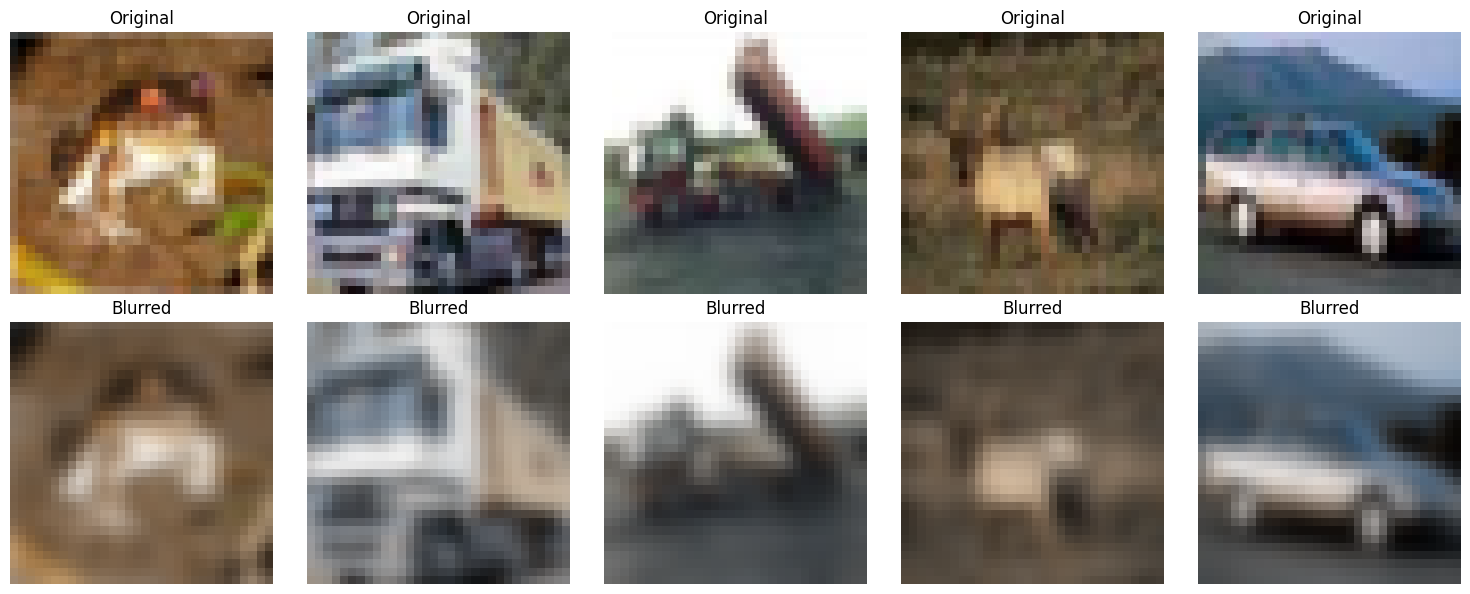

In [ ]:
# Apply Gaussian blur to distort images
def apply_gaussian_blur(images, sigma=1.0):
    return np.array([gaussian_filter(image, sigma=sigma) for image in images])

# Apply blur to training and test sets
x_train_blurred = apply_gaussian_blur(x_train)
x_test_blurred = apply_gaussian_blur(x_test)

# Show original vs blurred images before training
def show_original_vs_blurred(original, blurred, n=5):
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    for i in range(n):
        axes[0, i].imshow(original[i])
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(blurred[i])
        axes[1, i].set_title("Blurred")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize original vs blurred images
show_original_vs_blurred(x_train, x_train_blurred)


In [ ]:
# Normalize pixel values to [0, 1] range for both original and blurred datasets
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_blurred = x_train_blurred.astype('float32') / 255.0
x_test_blurred = x_test_blurred.astype('float32') / 255.0

# Reshape the data for LSTM input (samples, timesteps, features)
x_train = x_train.reshape(x_train.shape[0], 32, 32*3)  # Flatten 32x32x3 to 32x96 for LSTM
x_test = x_test.reshape(x_test.shape[0], 32, 32*3)
x_train_blurred = x_train_blurred.reshape(x_train_blurred.shape[0], 32, 32*3)
x_test_blurred = x_test_blurred.reshape(x_test_blurred.shape[0], 32, 32*3)


In [ ]:
# Build the LSTM model for image reconstruction
model = models.Sequential([
    layers.LSTM(128, input_shape=(32, 32*3), return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(32*3))
])

# Compile the model with MSE loss
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 32, 128)             │         115,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 32, 64)              │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 32, 96)              │           6,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 170,848 (667.38 KB)

 Trainable params: 170,848 (667.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(x_train_blurred, x_train, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - loss: 0.0431 - val_loss: 0.0063
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 130ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 127ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 124ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 126ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 122ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 123ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 12/20
625/625

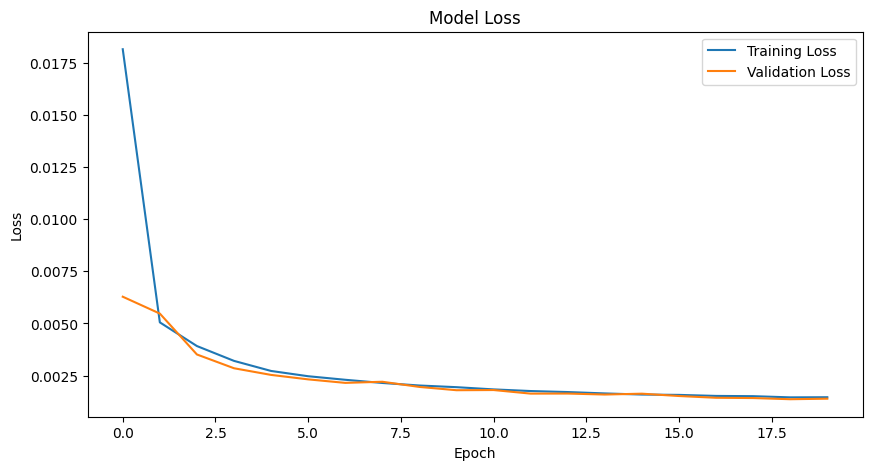

In [ ]:
# Plot training history (Training Loss and Validation Loss)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step


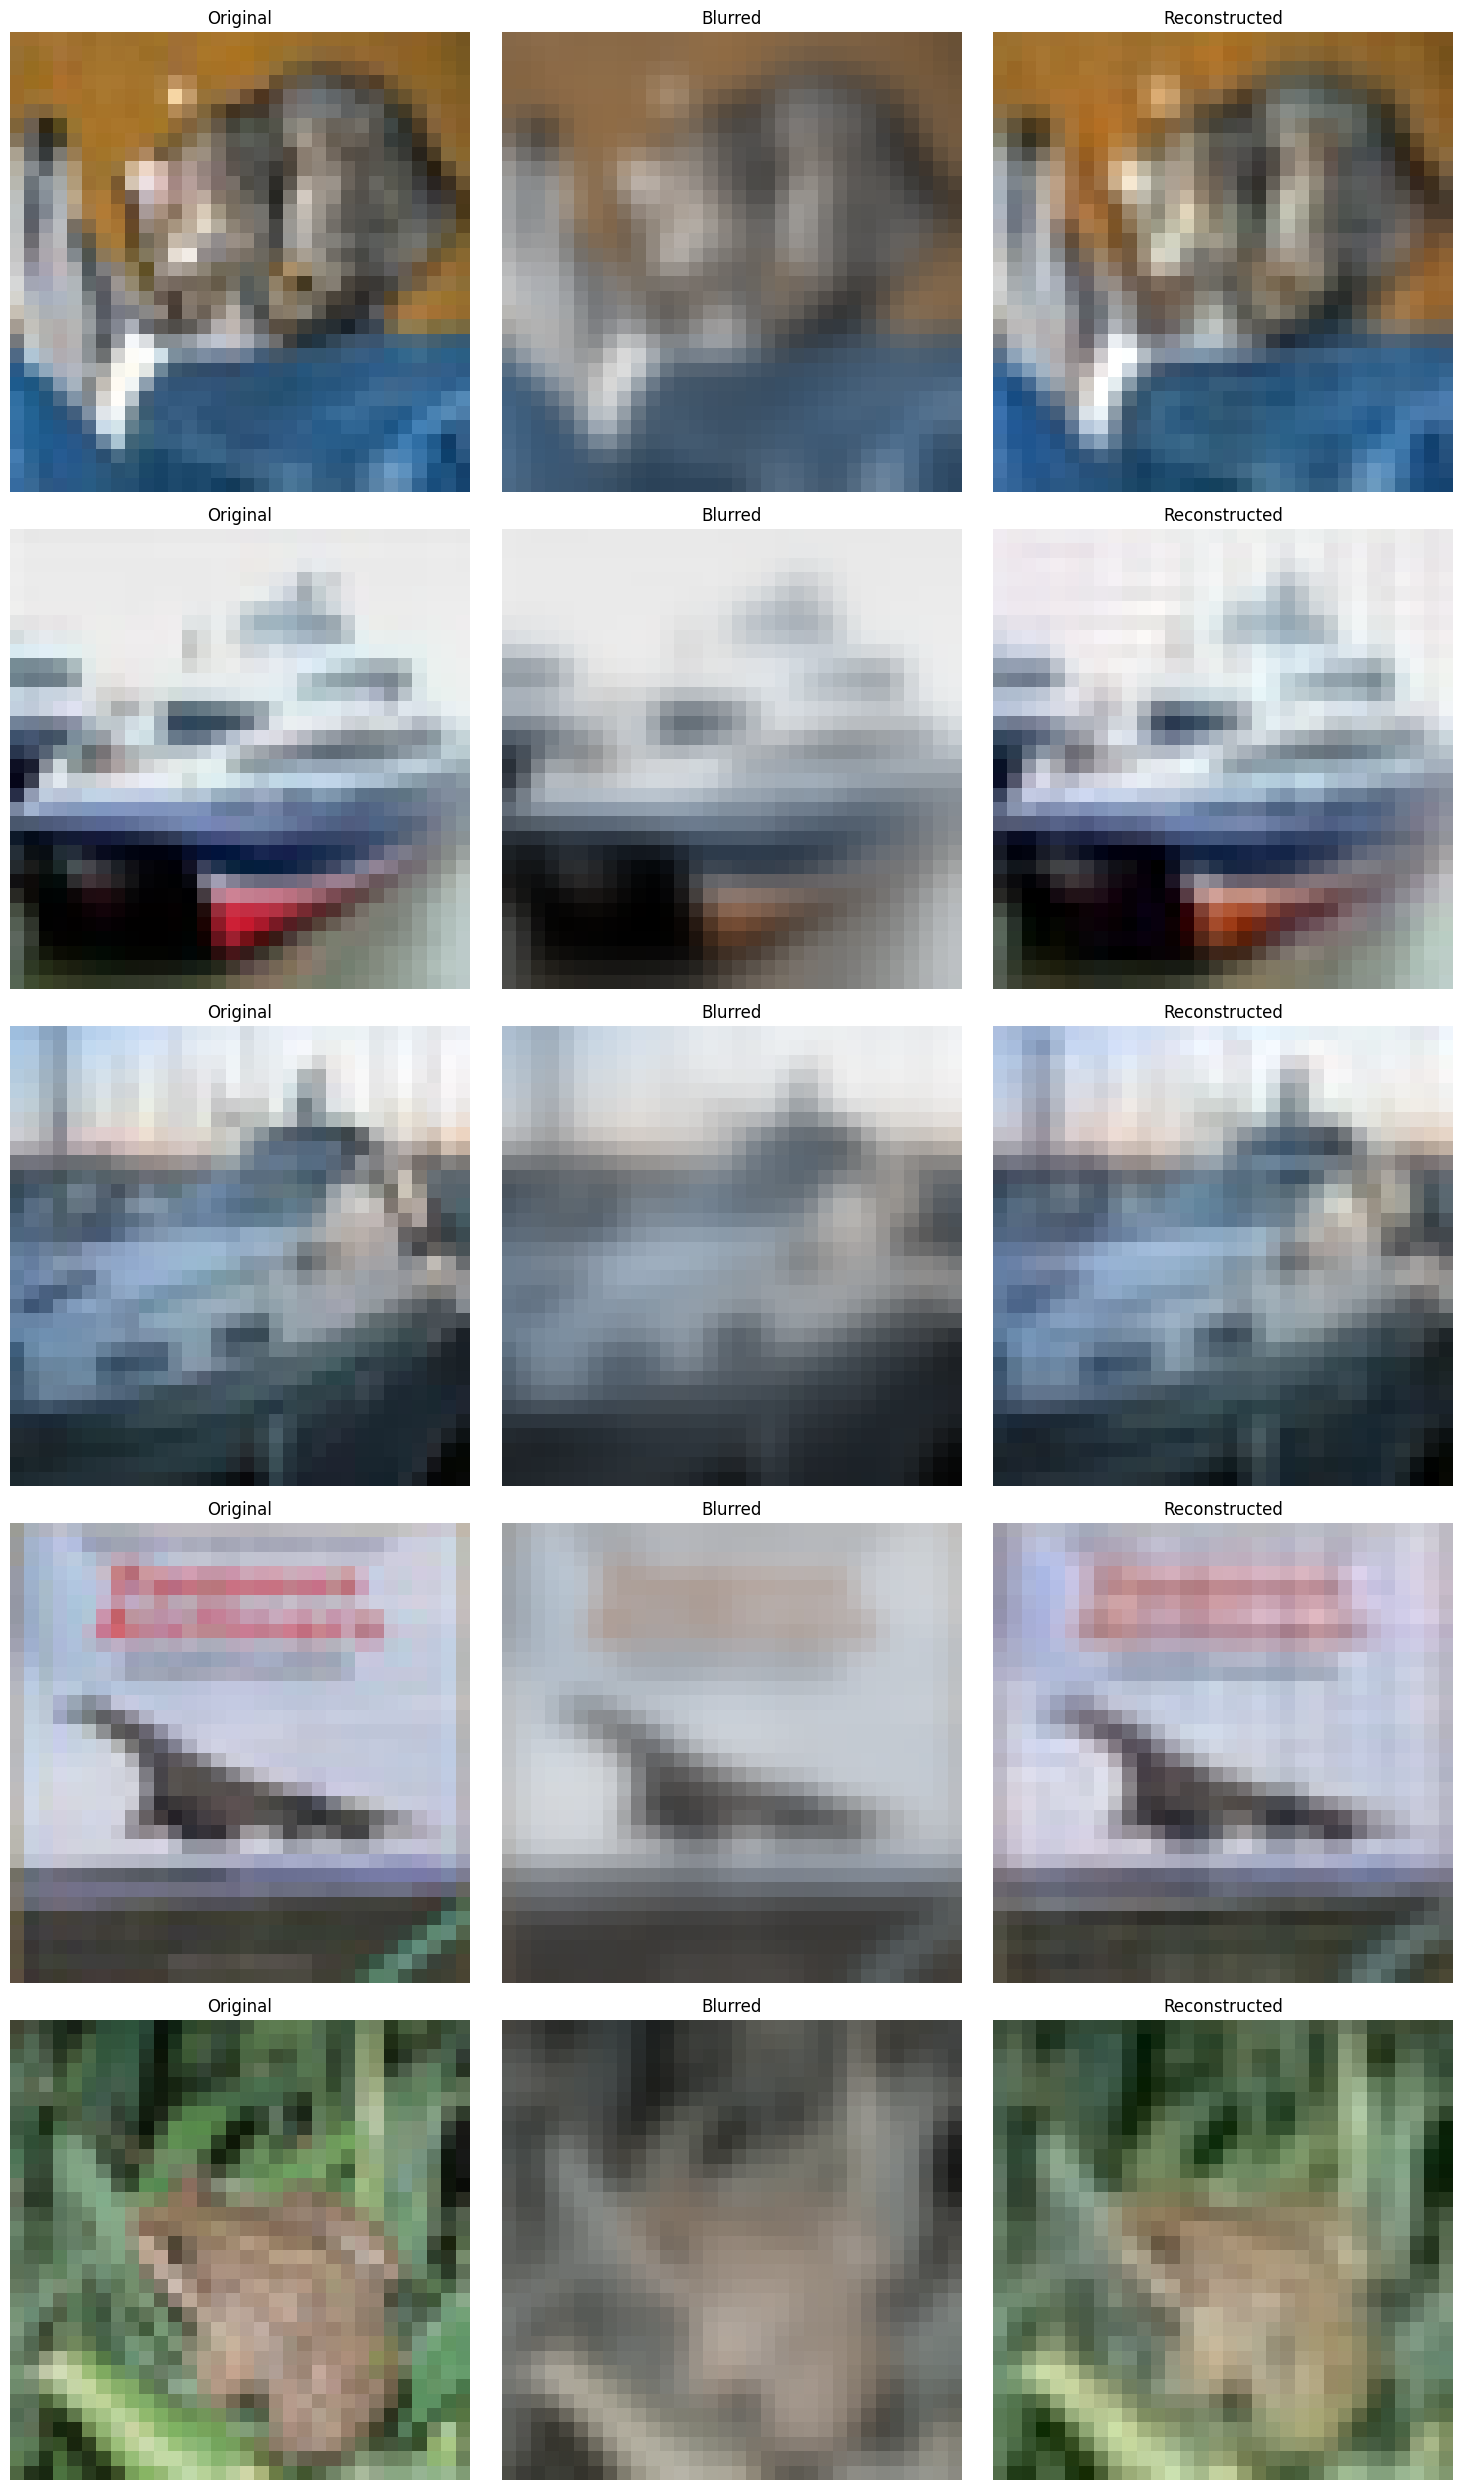

In [ ]:
# Generate reconstructed images using the trained model
test_reconstructed = model.predict(x_test_blurred[:5])

# Visualization function for Original, Blurred, and Reconstructed images
def plot_reconstructed_images_with_side_by_side(original, blurred, reconstructed, n=5):
    fig, axes = plt.subplots(n, 3, figsize=(15, 5 * n))
    for i in range(n):
        # Original image
        axes[i, 0].imshow(original[i].reshape(32, 32, 3))
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Blurred image
        axes[i, 1].imshow(blurred[i].reshape(32, 32, 3))
        axes[i, 1].set_title("Blurred")
        axes[i, 1].axis('off')

        # Reconstructed image
        axes[i, 2].imshow(reconstructed[i].reshape(32, 32, 3))
        axes[i, 2].set_title("Reconstructed")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Plot Original, Blurred, and Reconstructed images
plot_reconstructed_images_with_side_by_side(x_test[:5], x_test_blurred[:5], test_reconstructed)
